<a href="https://colab.research.google.com/github/Colossus08/ML-Assignment-2/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Approach

## 1.1 Data Exploration and Understanding

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML_A-2/Image_classification_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/2445.png   
  inflating: patch_images/19898.png  
  inflating: patch_images/10102.png  
  inflating: patch_images/1164.png   
  inflating: patch_images/9538.png   
  inflating: patch_images/7515.png   
  inflating: patch_images/11234.png  
  inflating: patch_images/3773.png   
  inflating: patch_images/19668.png  
  inflating: patch_images/5302.png   
  inflating: patch_images/18576.png  
  inflating: patch_images/17645.png  
  inflating: patch_images/5464.png   
  inflating: patch_images/18210.png  
  inflating: patch_images/17123.png  
  inflating: patch_images/10894.png  
  inflating: patch_images/21491.png  
  inflating: patch_images/11552.png  
  inflating: patch_images/20957.png  
  inflating: patch_images/3015.png   
  inflating: patch_images/22198.png  
  inflating: patch_images/15734.png  
  inflating: patch_images/8140.png   
  inflating: patch_images/7273.png   
  inflating: patch_images/396.png    

In [ ]:
#!unzip '/content/Image_classification_data.zip'

unzip:  cannot find or open /content/Image_classification_data.zip, /content/Image_classification_data.zip.zip or /content/Image_classification_data.zip.ZIP.


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df=pd.read_csv('/content/data_labels_mainData.csv')

In [ ]:
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
df.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [ ]:
df.isnull().sum()

,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


In [ ]:
df.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [ ]:
len(df.value_counts('patientID'))

60

### EDA

The EDA process began by loading the metadata from

```
data_labels_mainData.csv
```
into a pandas DataFrame and performing initial checks.

#### Dataset Overview and Integrity
The dataset comprises 9896 entries, each corrponding to an image patch. Key columns identified are InstanceID, patientID, ImageName, cellTypeName (categorical), cellType (numerical), and isCancerous (binary). An initial check with the code,

```
df.isnull().sum()
```

 confirmed no missing values in the data, indicating a clean dataset ready for analysis. Basic statistics


```
df.describe()
```

provided ranges for numerical fields.

#### Class Imbalance Identification
##### Implications of Class Imbalance
1. **Biased Model Performance** - Imbalanced models tend to be biased towards majority classes, performing poorly on minority classes.

2. **Poor Generalisation** - The model may not learn the characteristics of the minority classes effectively due to insufficient exposure, leading to a higher rate of misclassification for important, yet less frequent, instances.

In [ ]:
df.value_counts('cellTypeName')

,count
cellTypeName,
epithelial,4079
inflammatory,2543
fibroblast,1888
others,1386


In [ ]:
df.value_counts('cellType')

,count
cellType,
2,4079
1,2543
0,1888
3,1386


##### Multiclass Class Imbalance
The output from the code


```
df.value_counts('cellTypeName')
```


 clearly indicates class imbalance in the dataset for the multiclass classification task. **Epithelial cells** (4079 instances) are the most frequent class. **Others** (1386 instances) and **Fibroblast** (1888 instances) are notably less frequent compared to Epithelial cells. **Inflammatory cells** (2543 instances) are in between.

The ratio between the most frequent class (epithelial) and the least frequent class (others) is approximately 4079/1386≈2.94. While not extreme, this level of imbalance is significant and needs to be addressed. The bar chart below provides a visual representation of this distribution:

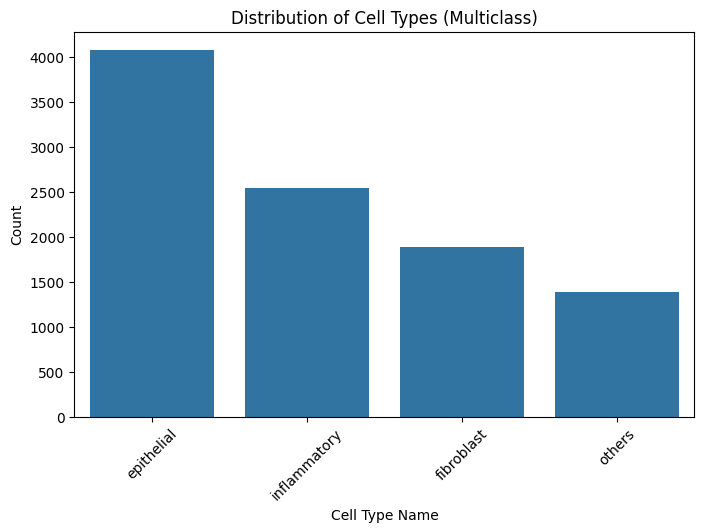

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='cellTypeName', order=df['cellTypeName'].value_counts().index)
plt.title('Distribution of Cell Types (Multiclass)')
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This visual confirms that 'Epithelial' dominates, while 'Others' and 'Fibroblast' are considerably less represented. This needs to be addressed during modeling.

In [ ]:
df.value_counts('isCancerous')

,count
isCancerous,
0,5817
1,4079


##### Binary Class Imbalance
There is a moderate imbalance in the binary classification data seen in the code


```
df.value_counts('isCancerous')
```


with **non-cancerous samples** (5817 instances) outnumbering **cancerous samples** (4079 instances). The ratio is approximately 5817/4079≈1.43. While less severe than the multiclass imbalance among the rarer types, this still needs consideration during modeling and evaluation. The bar chart illustrates this difference:

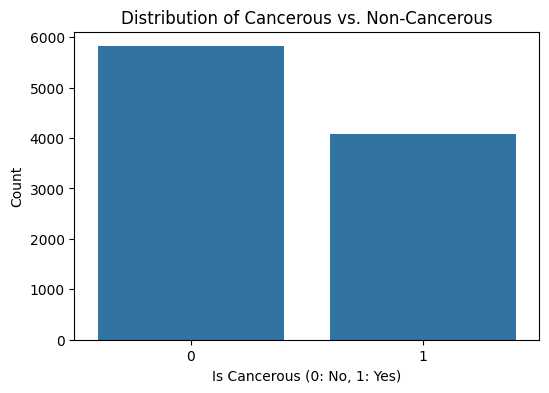

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isCancerous')
plt.title('Distribution of Cancerous vs. Non-Cancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

While less severe than the multiclass imbalance, this still warrants consideration during modeling and evaluation.

#### Relationship Between Cell Type and Cancer Status
Analysing the relationship between *cellTypeName* and *isCancerous* using a cross-tabulation and heatmap yields an important insight:

isCancerous      0     1
cellTypeName            
epithelial       0  4079
fibroblast    1888     0
inflammatory  2543     0
others        1386     0


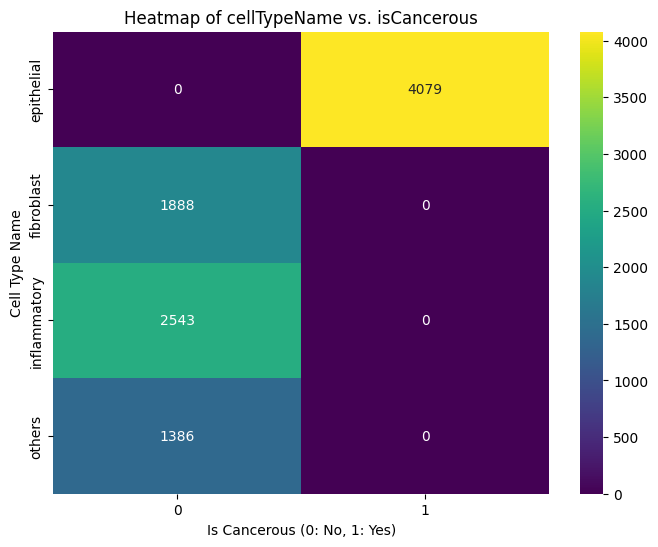

In [ ]:
crosstab_ct_cancer = pd.crosstab(df['cellTypeName'], df['isCancerous'])
print(crosstab_ct_cancer)

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_ct_cancer, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of cellTypeName vs. isCancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Cell Type Name')
plt.show()

The heatmap reveals a perfect correlation in this dataset:

- All Epithelial cell samples (4079) are labeled as cancerous (1)
- All samples from the other three cell types (Fibroblast, Inflammatory, Others, totaling 5817) are labeled as non-cancerous (0).

This means the binary task is effectively distinguishing epithelial cells from the rest. This strong link should be heavily considered in model interpretation.

The EDA confirms a clean dataset of 9896 image patches from 60 patients. Moderate class imbalance exists in both the multiclass (ratio ≈ 2.94) and binary (ratio ≈ 1.43) target variables. A significant finding is the perfect correlation between the 'epithelial' type and 'cancerous' status within this data. These insights, especially the imbalance and feature correlation, are key for planning the modeling phase, selecting appropriate techniques, and choosing relevant evaluation metrics.

## 1.2 Evaluation Framework


The selection of appropriate performance metrics is important for evaluating the effectiveness of the machine learning models, most especially in domains like medical image analysis where class imbalance is common and the cost of misclassification could be dire. Going beyond basic evaluation metrics gives a more varied understanding of the model's strengths and weaknesses.


---


### Binary Classification Metrics (*isCancerous*)
1. ***Accuracy*** - is the proportion of total predictions that were correct. This provides a general overview of the model's performance. However, it can be misleading in imbalanced datasets where a model might achieve high accuracy by simply predicting the majority class.

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$


2. ***Precision*** - is the proportion of instances predicted as positive, which were actually positive. This is important for understanding the rate of false alarms. In the context of medical image analysis, high precision means that when the model predicts cancer, it is likely correct, minimising false positives. False positives should be avoided as it can lead to patient distress or unneccessary procedures.

$$
\frac{TP}{TP + FP}
$$


3. ***Recall or Sensitivity*** - is the proportion of actual positive instances that were correctly identified by the model. This is often the most important metric in cancer detection (Boesch, 2025). High recall makes sure that the model identifies as many actual cancer cases as possible, minimising the number of missed diagnoses, which, as mentioned above, could bring severe consequences (Chubak et al., 2022).

$$
\frac{TP}{TP + FN}
$$


4. ***F1-Score*** - calculates the average of precision and recall. It provides a single score that balances. It is particularly useful when both false positives and false negatives are important, and especially valuable when dealing with class imbalance where accuracy by itself is not enough.

$$
\frac{Precision × Recall}{Precision + Recall} × 2
$$


5. ***Specificity*** - is the proportion of actual negative instances that were correctly identified. This complements recall. High specificity illustrates the model's ability to correctly identify non-cancerous cases, further helping minimise false alarms among healthy individuals (Chubak et al., 2022).

$$
\frac{TN}{TN + FP}
$$


6. ***AUC-ROC (Area Under the Receiver Operating Characteristic Curve)*** - is the area under the curve plotting recall against the false positive rate at various classification thresholds. This measures the model's ability to distinguish between the positiuve and negative classes across all thresholds. An AUC close to 1 indicates excellent discriminative ability, while 0.5 suggests performance no better than random guessing. It does not rely on a fixed threshold and offers a reliable measure of how well the model distinguishes between classes, making it especially useful for comparing models and handling imbalanced datasets (Marcus, 2019).

### Multiclass Classifcation (*cellTypeName*)

1. ***Accuracy***

2. ***Precision***

3. ***Recall***

4. ***F1-Score***

The metrics above are all important for identifying specific weaknesses. The model might perform well on common cell types but poorly on rarer, yet, potentially important types. These metrics reveal such imbalances in performance across classes.

5. ***Macro-Average Precision, Recall, and F1-Score*** - this calculates the metric for each class independantly and then averages these scores, giving equal weight to each class regardless of its frequency. These metrics are important for fairly evaluating performance on imbalanced multiclass datasets. Macro-averaging prevents the overall score from being dominated by the model's performance on the largest classes. It gives a better indication of whether the model's performance generalises well across **all** cell types, including minority ones (Leung, n.d.).

## 1.3 Model Selection and Justification

### Base Model Selection

For this task, Convolutional Neural Networks (**CNNs**) are the most appropriate model architecture. CNNs are specifically designed to process grid-like data, such as images, by automatically learning hierarchical spatial features like edges, textures, and complex morphological patterns directly from pixel data (LeCun et al., 1998). This capability is important for distinguishing subtle differences between various cell types or identifying cancerous tissues in histopathological slides.

### Multiclass Classification Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df[['ImageName','cellTypeName','cellType']],test_size=0.2,stratify=df['cellType'],random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
batch_size=32

In [ ]:
training_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

basemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
basemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
basehistory=basemodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1.2752 - sparse_categorical_accuracy: 0.4579 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.6924
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9463 - sparse_categorical_accuracy: 0.6469 - val_loss: 0.7944 - val_sparse_categorical_accuracy: 0.7126
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8549 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.7680 - val_sparse_categorical_accuracy: 0.7237
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.8245 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.7419 - val_sparse_categorical_accuracy: 0.7313
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8103 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.8590 - val_sparse_categorical_accuracy: 0.6712
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8209 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.7620 - val_sparse_categorical_accuracy: 0.7061
Epoch 7/

In [ ]:
basemodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

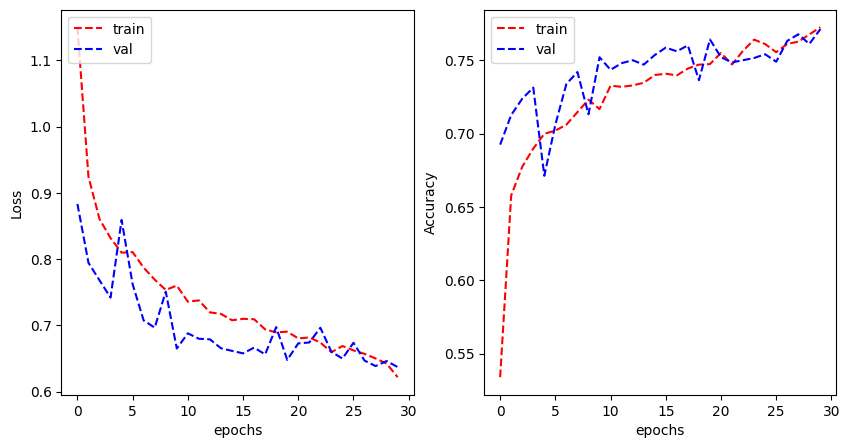

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(basehistory.history['loss'], 'r--')
plt.plot(basehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(basehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(basehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Increasing number of layers

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

incmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
incmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
inchistory=incmodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 1.3431 - sparse_categorical_accuracy: 0.4302 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.6525
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9333 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7162
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8890 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.7879 - val_sparse_categorical_accuracy: 0.7061
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.8495 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.7268
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8687 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7121
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8053 - sparse_categorical_accuracy: 0.7123 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.70

In [ ]:
incmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,526 (1.12 MB)

 Trainable params: 97,508 (380.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 195,018 (761.79 KB)

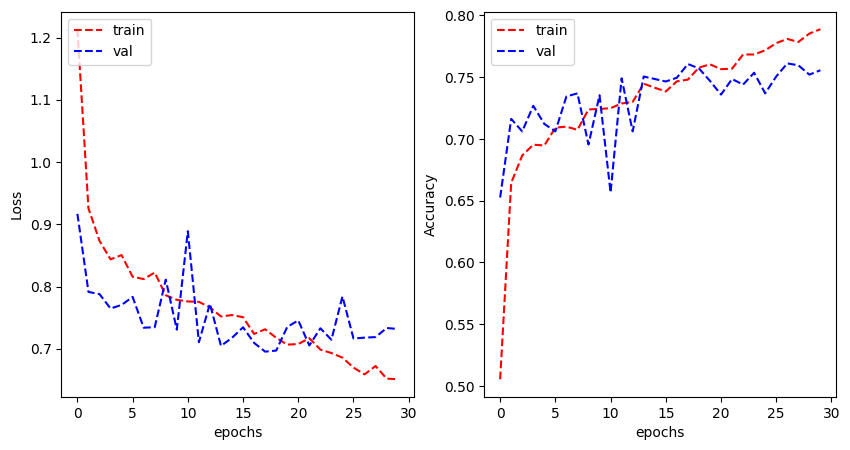

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(inchistory.history['loss'], 'r--')
plt.plot(inchistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(inchistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(inchistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Changing Dropout value

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

dropmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
dropmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
drophistory=dropmodel.fit(training_generator,epochs=40,validation_data=validation_generator)

Epoch 1/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 1.3428 - sparse_categorical_accuracy: 0.4100 - val_loss: 0.9671 - val_sparse_categorical_accuracy: 0.6217
Epoch 2/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0486 - sparse_categorical_accuracy: 0.5690 - val_loss: 0.8901 - val_sparse_categorical_accuracy: 0.6389
Epoch 3/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9575 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.8091 - val_sparse_categorical_accuracy: 0.7051
Epoch 4/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9224 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.6939
Epoch 5/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9295 - sparse_categorical_accuracy: 0.6527 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.6854
Epoch 6/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8843 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.7523 - val_sparse_categorical_accuracy: 0.717

In [ ]:
dropmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

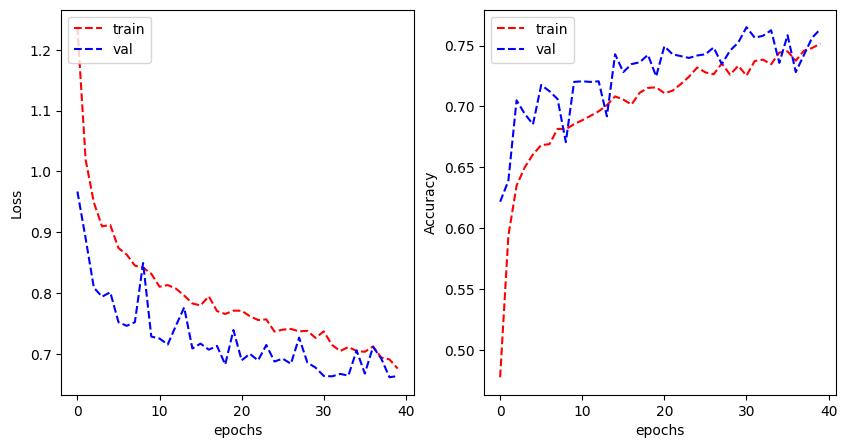

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(drophistory.history['loss'], 'r--')
plt.plot(drophistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(drophistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(drophistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Grayscaling images

In [ ]:
graytraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)


grayvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

graymodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,1)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
graymodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
grayhistory=graymodel.fit(graytraining_generator,epochs=30,validation_data=grayvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 1.3669 - sparse_categorical_accuracy: 0.3968 - val_loss: 1.2491 - val_sparse_categorical_accuracy: 0.4444
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.1962 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.0368 - val_sparse_categorical_accuracy: 0.6384
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.0602 - sparse_categorical_accuracy: 0.5857 - val_loss: 1.0394 - val_sparse_categorical_accuracy: 0.5965
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0470 - sparse_categorical_accuracy: 0.5891 - val_loss: 0.9515 - val_sparse_categorical_accuracy: 0.6510
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.0268 - sparse_categorical_accuracy: 0.6043 - val_loss: 0.9366 - val_sparse_categorical_accuracy: 0.6283
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.9834 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.9531 - val_sparse_categorical_accuracy: 0.6232
Epoch 7/30
62/62 ━━━━

In [ ]:
graymodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,622 (1.39 MB)

 Trainable params: 121,540 (474.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,082 (949.54 KB)

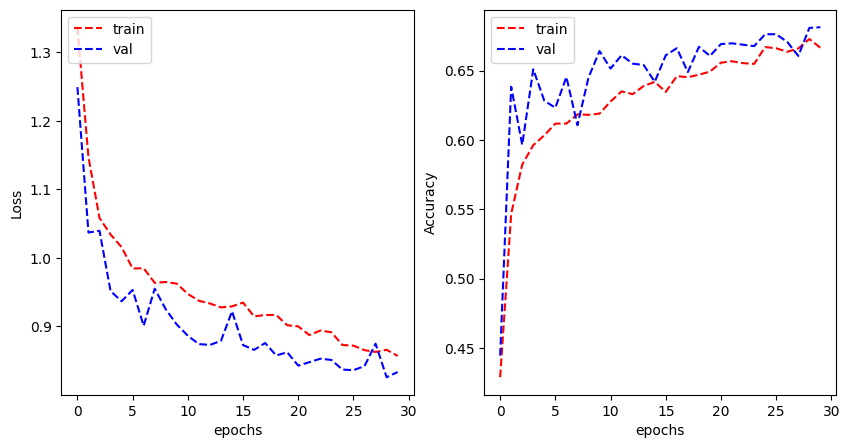

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(grayhistory.history['loss'], 'r--')
plt.plot(grayhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(grayhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(grayhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Batch Normalization

In [ ]:
batchtraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


batchvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

batchmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
batchmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
batchhistory=batchmodel.fit(batchtraining_generator,epochs=30,validation_data=batchvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.5433 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.6076
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.8209 - sparse_categorical_accuracy: 0.6978 - val_loss: 1.1148 - val_sparse_categorical_accuracy: 0.5636
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.7641 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.7682 - val_sparse_categorical_accuracy: 0.6884
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7268 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.9399 - val_sparse_categorical_accuracy: 0.6727
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.7430 - val_loss: 1.5766 - val_sparse_categorical_accuracy: 0.4333
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.7409 - val_loss: 1.1271 - val_sparse_categorical_accuracy: 0.6530
Epoch 7/30
62/62 ━━

In [ ]:
batchmodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,862 (1.40 MB)

 Trainable params: 122,244 (477.52 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 244,490 (955.04 KB)

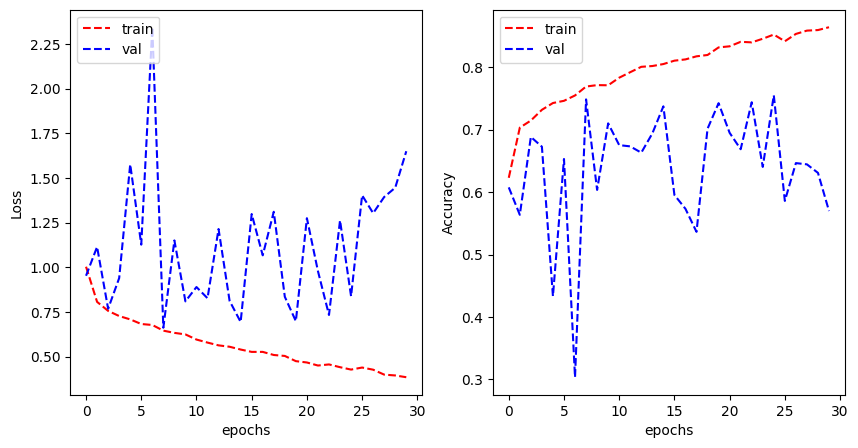

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(batchhistory.history['loss'], 'r--')
plt.plot(batchhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(batchhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(batchhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Data Augmentation

In [ ]:
aug_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
  )

aug_val_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last'
  )

In [ ]:
augtraining_generator=aug_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


augvalidation_generator=aug_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    shuffle=False
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

augmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
augmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
aughistory=augmodel.fit(augtraining_generator,epochs=30,validation_data=augvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 1.3311 - sparse_categorical_accuracy: 0.4147 - val_loss: 1.0319 - val_sparse_categorical_accuracy: 0.6116
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 1.0622 - sparse_categorical_accuracy: 0.5790 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.6263
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.9725 - sparse_categorical_accuracy: 0.6303 - val_loss: 0.8473 - val_sparse_categorical_accuracy: 0.6808
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.6647 - val_loss: 0.8169 - val_sparse_categorical_accuracy: 0.6864
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.8802 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.8569 - val_sparse_categorical_accuracy: 0.6626
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.8825 - sparse_categorical_accuracy: 0.6687 - val_loss: 0.7584 - val_sparse_categorical_accuracy: 0.7187
Epoch 7/30
62/62

In [ ]:
augmodel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

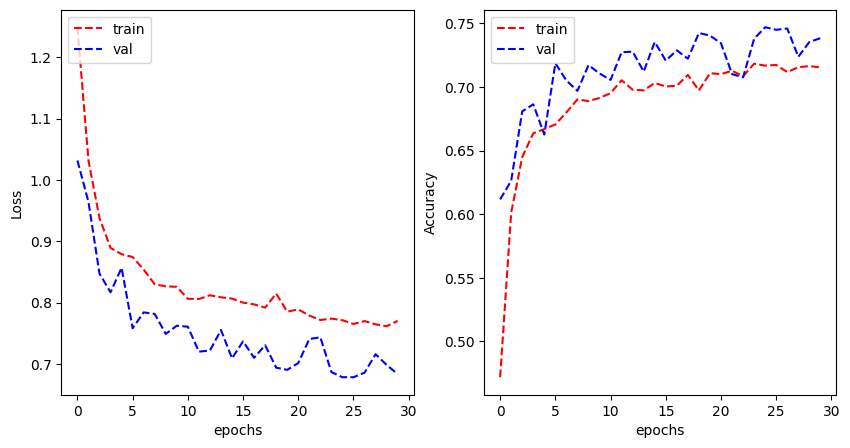

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(aughistory.history['loss'], 'r--')
plt.plot(aughistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(aughistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(aughistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Sampling imbalanced classes

In [ ]:
from sklearn.utils import class_weight
classes=np.unique(train_df['cellType'].values)
weights=class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['cellType'].values
)

weight_dict=dict(zip(classes,weights))

In [ ]:
sampletraining_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last'
)
samplevalidation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
sampletraining_generator=sampletraining_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse',
)


samplevalidation_generator=samplevalidation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.0005
OUTPUT_CLASSES = 4

samplemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
samplemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
samplehistory=samplemodel.fit(sampletraining_generator,epochs=30,validation_data=samplevalidation_generator,class_weight=weight_dict)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 1.5424 - sparse_categorical_accuracy: 0.4097 - val_loss: 1.0196 - val_sparse_categorical_accuracy: 0.6086
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1103 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.9009 - val_sparse_categorical_accuracy: 0.6338
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.0782 - sparse_categorical_accuracy: 0.5872 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.6848
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.9514 - sparse_categorical_accuracy: 0.6363 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7247
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.9172 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.7544 - val_sparse_categorical_accuracy: 0.7465
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.8616 - sparse_categorical_accuracy: 0.6829 - val_loss: 0.7511 - val_sparse_categorical_accuracy: 0.7404
Epoch 7/

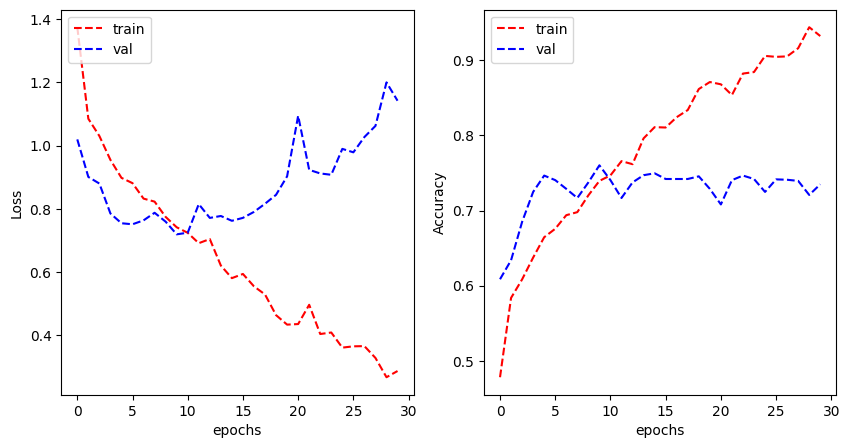

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(samplehistory.history['loss'], 'r--')
plt.plot(samplehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(samplehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(samplehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Binary Classification Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
bin_train_df,bin_val_df=train_test_split(df[['ImageName','isCancerous']],test_size=0.2,stratify=df['isCancerous'],random_state=42)

In [ ]:
bin_train_df['isCancerous']=bin_train_df['isCancerous'].astype(str)
bin_val_df['isCancerous']=bin_val_df['isCancerous'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


bin_training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
bin_validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
bin_batch_size=32

In [ ]:
bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)


bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    shuffle=False
)


Found 7916 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
early_stopping_bin = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint_dir_bin = './model_checkpoints_bin'
if not os.path.exists(checkpoint_dir_bin):
    os.makedirs(checkpoint_dir_bin)

In [ ]:
model_checkpoint_bin = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_bin, 'best_bin_model_opt_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
reduce_lr_bin = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_list_bin = [early_stopping_bin, model_checkpoint_bin, reduce_lr_bin]

epochs_bin = 50

steps_per_epoch_bin = len(bin_training_generator)
validation_steps_bin = len(bin_validation_generator)

In [ ]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
bin_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,921 (476.25 KB)

 Trainable params: 121,921 (476.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bin_history = bin_model.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6778 - loss: 0.6213
Epoch 1: val_accuracy improved from -inf to 0.82727, saving model to ./model_checkpoints_bin/best_bin_model_opt_epoch_01_val_acc_0.8273.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6793 - loss: 0.6193 - val_accuracy: 0.8273 - val_loss: 0.3942 - learning_rate: 0.0010
Epoch 2/50
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8582 - loss: 0.3598
Epoch 2: val_accuracy improved from 0.82727 to 0.84040, saving model to ./model_checkpoints_bin/best_bin_model_opt_epoch_02_val_acc_0.8404.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8581 - loss: 0.3598 - val_accuracy: 0.8404 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 3/50
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8589 - loss: 0.3563
Epoch 3: val_accuracy improved from 0.84040 to 0.87879, saving model to ./model_checkpoints_bin/best_bin_model_opt_epoch_03_val_acc_0.8788.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12m

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
bin_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [ ]:
def plot_training_history(history, model_name="Model"):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'b--', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0.78, 0.94])
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'r--', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b--', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim([0.18, 0.5])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

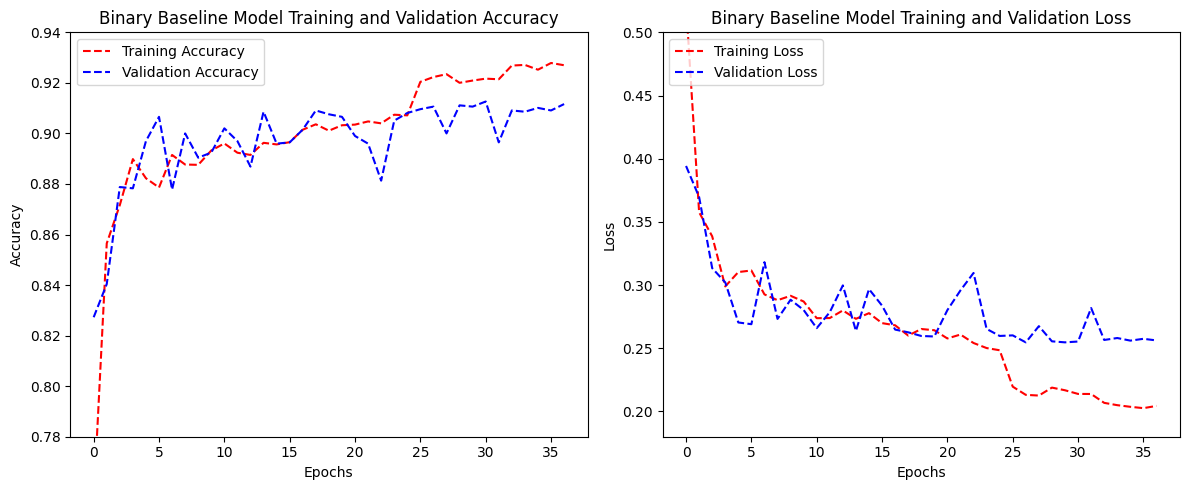

In [ ]:
plot_training_history(bin_history, model_name= "Binary Baseline Model")

#### Addressing Class Imbalance

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
class_labels_binary = np.unique(bin_training_generator.classes)

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_labels_binary = np.unique(bin_training_generator.classes)
y_train_binary = bin_training_generator.classes

class_weights_binary_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels_binary,
    y=y_train_binary
)

class_weight_dict_binary = dict(zip(class_labels_binary, class_weights_binary_arr))

print(f"Binary Class Labels: {class_labels_binary}")
print(f"Binary Class Weights: {class_weight_dict_binary}")

Binary Class Labels: [0 1]
Binary Class Weights: {np.int64(0): np.float64(0.8506339995701698), np.int64(1): np.float64(1.2129941771376034)}


#### Batch Normalization

In [ ]:
batch_bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)


batch_bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)

Found 7916 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [ ]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
bin_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
bin_normalized=bin_model.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8277 - loss: 0.4190
Epoch 1: val_accuracy did not improve from 0.91263
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8279 - loss: 0.4186 - val_accuracy: 0.4667 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 2/50
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8708 - loss: 0.3406
Epoch 2: val_accuracy did not improve from 0.91263
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8709 - loss: 0.3403 - val_accuracy: 0.7495 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8970 - loss: 0.2912
Epoch 3: val_accuracy did not improve from 0.91263
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8970 - loss: 0.2913 - val_accuracy: 0.8631 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 4/50
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8797 - loss: 0.3139
Epoch 4: val_accuracy did not improve from 0.91263
248/248 ━━━━━━━━━━━━━

In [ ]:
bin_normalized.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

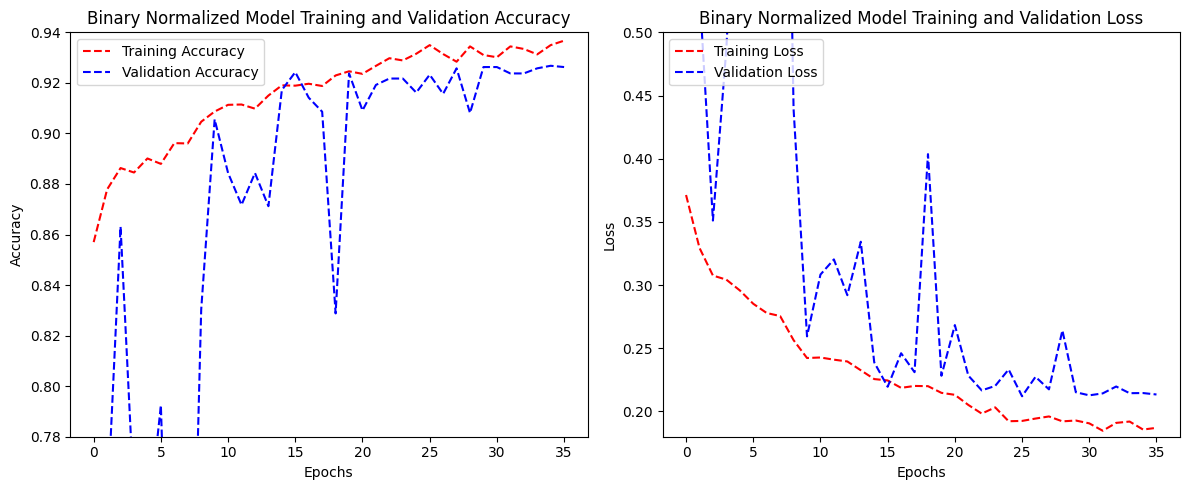

In [ ]:
plot_training_history(bin_normalized, model_name= "Binary Normalized Model")

#### Global Pooling

In [ ]:
reg_lambda = 0.001

IMG_HEIGHT = 27
IMG_WIDTH = 27
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_optimized = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="OptimizedBinModel")

In [ ]:
initial_learning_rate_bin = 0.001
optimizer_bin = Adam(learning_rate=initial_learning_rate_bin)
bin_model_optimized.compile(optimizer=optimizer_bin, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
bin_model_optimized.summary()

Model: "OptimizedBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
bin_model_optimized = bin_model_optimized.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8327 - loss: 0.4291
Epoch 1: val_accuracy did not improve from 0.92677
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8329 - loss: 0.4288 - val_accuracy: 0.8399 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 2/50
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8807 - loss: 0.3390
Epoch 2: val_accuracy did not improve from 0.92677
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8807 - loss: 0.3389 - val_accuracy: 0.7495 - val_loss: 0.5124 - learning_rate: 0.0010
Epoch 3/50
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8865 - loss: 0.3186
Epoch 3: val_accuracy did not improve from 0.92677
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8865 - loss: 0.3185 - val_accuracy: 0.8793 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8988 - loss: 0.2911
Epoch 4: val_accuracy did not improve from 0.92677
248/248 ━━━━━━━━━━━━━

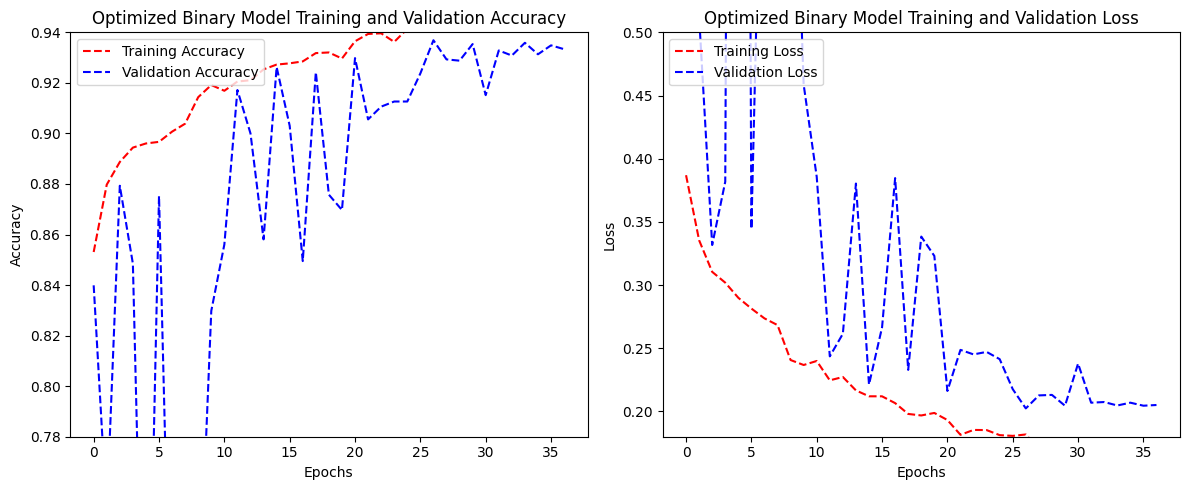

In [ ]:
plot_training_history(bin_model_optimized, model_name="Optimized Binary Model")

####  Data Augmentation

In [191]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [192]:
bin_training_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [193]:
bin_validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

In [194]:
bin_training_generator_augmented = bin_training_augmented.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)

bin_validation_generator_no_aug = bin_validation_datagen_augmented.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 7916 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [195]:
from tensorflow.keras.regularizers import l2

In [196]:
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_augmented = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="OptimizedBinModel")

In [197]:
initial_learning_rate_bin = 0.001
optimizer_bin_augmented = Adam(learning_rate=initial_learning_rate_bin)

bin_model_augmented.compile(optimizer=optimizer_bin_augmented,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

bin_model_augmented.summary()

Model: "OptimizedBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [198]:
checkpoint_dir_bin_enhanced = './model_checkpoints_bin_enhanced'
if not os.path.exists(checkpoint_dir_bin_enhanced):
    os.makedirs(checkpoint_dir_bin_enhanced)
    print(f"Created checkpoint directory: {checkpoint_dir_bin_enhanced}")



In [199]:
epochs_bin_enhanced_run = 50
steps_per_epoch_bin_aug = len(bin_training_generator_augmented)
validation_steps_bin_no_aug = len(bin_validation_generator_no_aug)

In [201]:
history_bin_augmented = bin_model_augmented.fit(
     bin_training_generator_augmented,
     epochs=epochs_bin_enhanced_run,
     validation_data=bin_validation_generator_no_aug,
     callbacks=callbacks_list_bin,
     class_weight=class_weight_dict_binary,
     steps_per_epoch=steps_per_epoch_bin_aug,
     validation_steps=validation_steps_bin_no_aug
 )

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9034 - loss: 0.2209
Epoch 1: val_accuracy did not improve from 0.91313
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9034 - loss: 0.2209 - val_accuracy: 0.8859 - val_loss: 0.3036 - learning_rate: 2.0000e-04
Epoch 2/50
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9003 - loss: 0.2142
Epoch 2: val_accuracy did not improve from 0.91313
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9003 - loss: 0.2142 - val_accuracy: 0.8197 - val_loss: 0.4287 - learning_rate: 2.0000e-04
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9033 - loss: 0.2114
Epoch 3: val_accuracy did not improve from 0.91313
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9033 - loss: 0.2114 - val_accuracy: 0.9061 - val_loss: 0.2426 - learning_rate: 2.0000e-04
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9047 - loss: 0.2133
Epoch 4: val_accuracy did not improve from 0.91313
248/248 ━━

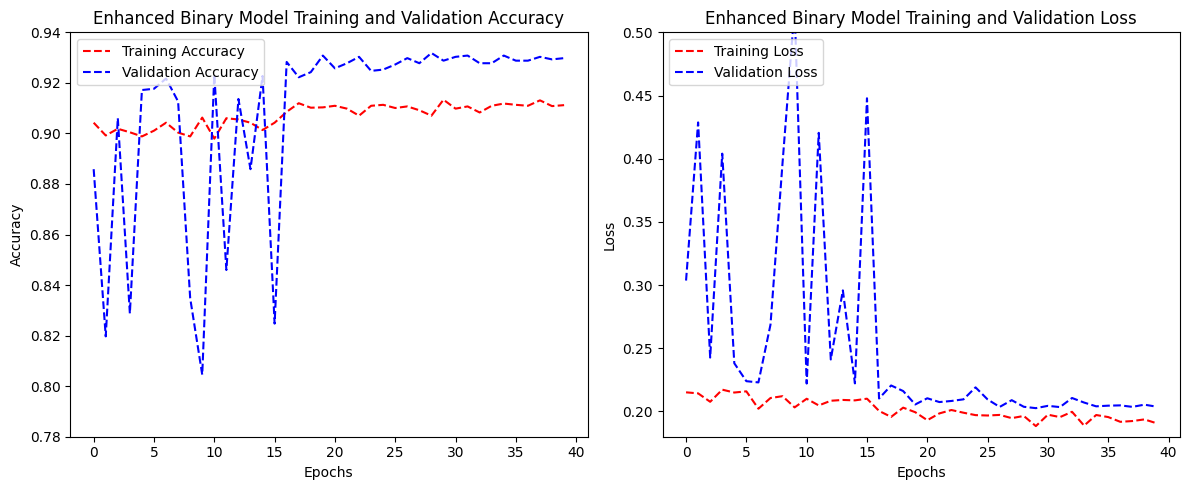

In [202]:
plot_training_history(history_bin_augmented, model_name="Enhanced Binary Model")

In [203]:
bin_validation_generator_no_aug.reset()
loss, accuracy = bin_model_augmented.evaluate(bin_validation_generator_no_aug,
                                             steps=len(bin_validation_generator_no_aug),
                                             verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9218 - loss: 0.2217
Validation Loss: 0.2026
Validation Accuracy: 0.9288


## 1.4 Model Optimisation

### Binary Classification (isCancerous)

The baseline CNN model for binary classification (determining isCancerous) underwent several optimisation strategies to enhance its performance, strength, and generalisation capabilities. These strategies focused on addressing class imbalance, refining the model architecture, incorporating regularisation techniques, and augmenting the training data. A sturdy training process was established using callbacks like *EarlyStopping* to prevent overfitting by halting training when validation loss ceased to improve, *ModelCheckpoint* to save the best performing model based on validation accuracy, and *ReduceLROnPlateau* to adjust the learning rate dynamically if training stagnated.

The optimisation steps included:
1. **Addressing Class Imbalance with Class Weighting:**

Given the moderate imbalance between cancerous (4079 instances) and non-cancerous (5817 instances) samples, class was used during model training. Weights were computed to give more importance to the minority class (cancerous samples), helping the model to learn its features more effectively and avoid bias towards the majority class. The calculated class weights were approximately 0.85 for the non-cancerous class (0) and 1.21 for the cancerous (1). This was applied via the **class_weight** parameter in the **fit** method.

2. **Architectural Enhancements and Regularisation:**

The baseline model architecture, which already included L2 regularisation in Conv2D and Dense layers and Dropout after a dense layer to mitigate overfitting, was further enhanced:

- **Batch Normalisation**: Batch Normalisation Layers were added after each *Conv2D* layer (before activation) and after the main *Dense* layer (before activation). This technique helps to stabilise and accelerate the training process by normalising the inputs to each layer, reducing internal covariate shift.

- **Global Average Pooling**: Instead of a *Flatten* layer before the dense layers, *GlobalAveragePooling2D* was introduced. This layer reduces the spatial dimensions of the feature maps by taking the average of each feature map, significantly reducing the number of parameters, which can help prevent overfitting and improve model generalisation.

3. **Data Augmentation:**

To increase the diversity of the training data and improve the model's ability to generalise to unseen images, data augmentation techniques were applied to the training set. These included:

- Rescaling pixel values to the [0, 1] range.
- Random rotations (up to 20 degrees).
- Random width and height shifts (up to 10% of the dimension).
- Random shear transformations.
- Random zoom (up to 10%).
- Horizontal and vertical flips.
- Using 'reflect' mode to fill in newly created pixels during transformations.

The validation data was only rescaled, without further augmentation, to ensure a consistent evaluation set. The model incorporating these architectural changes and trained with augmented data was referred to as *bin_model_augmented*.

The combination of these techniques like Batch Normalisation and Global Average Pooling, alongside data augmentation, aimed to produce a well-optimised binary classification model with improved performance on predicting the target variable. The Adam optimiser was used with an initial learning rate, which was then managed by the ReduceLROnPlateau callback.

## 1.5 Model Performance and Robustness

### isCancerous

# 2. Independent Evaluation

 ## 2.1 Comparative Analysis

## 2.2 Critical Discussion

# References
- Alzubaidi, L., Al-Amidie, M., Al-Asadi, A., Humaidi, A. J., Al-Shamma, O., Fadhel, M. A., Zhang, J., Santamaría, J., & Duan, Y. (2021). Novel Transfer Learning Approach for Medical Imaging with Limited Labeled Data. Cancers, 13(7), 1590. https://doi.org/10.3390/cancers13071590

- Boesch, G. (2025, January 31). Precision vs. Recall – Full Guide to Understanding Model Output. viso.ai. https://viso.ai/computer-vision/precision-recall/

- Chubak, J., Burnett-Hartman, A. N., Barlow, W. E., Corley, D. A., Croswell, J. M., Neslund-Dudas, C., Vachani, A., Silver, M. I., Tiro, J. A., & Kamineni, A. (2022). Estimating cancer screening sensitivity and specificity using healthcare utilization data: Defining the accuracy assessment interval. Cancer Epidemiology Biomarkers & Prevention, 31(8), 1517–1520. https://doi.org/10.1158/1055-9965.epi-22-0232 Exact Sciences explains: sensitivity and specificity. (n.d.).

- Exact Sciences. https://www.exactsciences.com/newsroom/news-and-stories/exact-sciences-explains-sensitivity-and-specificity

- Gu, C., & Lee, M. (2024). Deep Transfer Learning Using Real-World Image Features for Medical Image Classification, with a Case Study on Pneumonia X-ray Images. Bioengineering, 11(4), 406. https://doi.org/10.3390/bioengineering11040406

- How to display a fraction in a Markdown cell? (2023, July 28). Jupyter Community Forum. https://discourse.jupyter.org/t/how-to-display-a-fraction-in-a-markdown-cell/20657

- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-Based Learning Applied to Document Recognition. In IEEE, IEEE. IEEE. https://ieeexplore.ieee.org/document/726791

- Leung, K. (n.d.). Micro, Macro & Weighted Averages of F1 Score, Clearly Explained - KDnuggets. KDnuggets. https://www.kdnuggets.com/2023/01/micro-macro-weighted-averages-f1-score-clearly-explained.html

- Mandrekar, J. N. (2010). Receiver operating characteristic curve in diagnostic test assessment. Journal of Thoracic Oncology, 5(9), 1315–1316. https://doi.org/10.1097/jto.0b013e3181ec173d

- Marcus, P. M. (2019, November 1). Performance measures. Assessment of Cancer Screening: A Primer - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK550207/

- Raju, A. S. N., Venkatesh, K., Gatla, R. K., Konakalla, E. P., Eid, M. M., Titova, N., Ghoneim, S. S. M., & Ghaly, R. N. R. (2025). Colorectal cancer detection with enhanced precision using a hybrid supervised and unsupervised learning approach. Scientific Reports, 15(1). https://doi.org/10.1038/s41598-025-86590-y

- Using ROC curves to identify the most accurate test – Cancer Prevention and Screening Blog. (n.d.). https://cancerprevention.qmul.ac.uk/index.php/using-roc-curves-to-identify-the-most-accurate-test/#:~:text=The%20area%20under%20this%20curve,represented%20in%20a%20ROC%20graph.